# Shengyan Gao 4626-8392-42

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import graphviz as gr

from matplotlib import style
import seaborn as sns
style.use("fivethirtyeight")

In [2]:
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [3]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [4]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)
    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)
    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

In [5]:
def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [6]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
   
    nvar = p+2 
    corr = 0.5 

    if conf==False:
        conf_mult = 0 
    else: 
        conf_mult=1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1])
    C = allX[:,1].reshape([N,1]) 
    X = allX[:,2:] 
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)


In [7]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


In [8]:
def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


# 1a Experiments with no covariates in the DGP

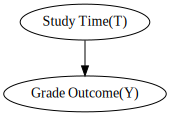

In [9]:
g = gr.Digraph()
g.edge("Study Time(T)", "Grade Outcome(Y)")

g

In [10]:
tau = 2
corr = .5
conf=False
p = 10
p0 = 0 
Nrange = range(10,1000,5)
flagX=1
N=500
Y,Z,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)


100%|████████████████████████████████████████| 198/198 [00:00<00:00, 343.39it/s]


In [11]:
data = np.concatenate([Y,Z,X],axis=1)
data = pd.DataFrame(data)
data.to_csv('part1.csv')

# When N=100

In [12]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(1.7917392460008188, 0.19911386364232916)

In [13]:
const = np.ones([N,1])

In [14]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     80.97
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           1.80e-14
Time:                        01:03:04   Log-Likelihood:                -140.44
No. Observations:                 100   AIC:                             284.9
Df Residuals:                      98   BIC:                             290.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7917      0.199      8.999      0.000       1.397       2.187
const          0.0969      0.141      0.688      0.493      -0.183       0.376
==============================================================================
Omnibus:                        1.120   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.571   Jarque-Bera (JB):                0.658
Skew:                          -0.156   Prob(JB):                        0.719
Kurtosis:                       3.246   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# When N=1000

In [15]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(2.0290623083236534, 0.06104221899773056)

In [16]:
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     1105.
Date:                Fri, 15 Apr 2022   Prob (F-statistic):          1.05e-163
Time:                        01:03:04   Log-Likelihood:                -1382.5
No. Observations:                1000   AIC:                             2769.
Df Residuals:                     998   BIC:                             2779.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0291      0.061     33.240      0.000       1.909       2.149
const         -0.0289      0.043     -0.670      0.503      -0.114       0.056
==============================================================================
Omnibus:                        2.181   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.336   Jarque-Bera (JB):                2.037
Skew:                           0.092   Prob(JB):                        0.361
Kurtosis:                       3.122   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Run a Monte Carlo experiment, and calculate the bias, RMSE and size for N=100 and N=1000

In [17]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 166.74it/s]


In [18]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.0036535040479215536, RMSE=0.20169451721500303, size=0.0525
N=1000: bias=0.0003535870538214996, RMSE=0.06441122885052279, size=0.058


# 1b Experiments with covariates in the DGP

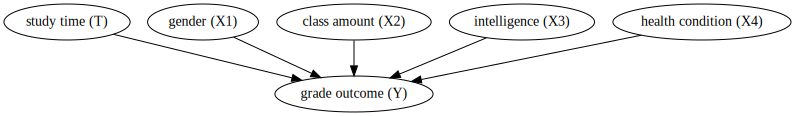

In [19]:
g=gr.Digraph()
g.edge("study time (T)", "grade outcome (Y)")
g.edge("gender (X1)", "grade outcome (Y)")
g.edge("class amount (X2)", "grade outcome (Y)")
g.edge("intelligence (X3)", "grade outcome (Y)")
g.edge("health condition (X4)", "grade outcome (Y)")

g

In [20]:
tau = 2
corr = 0.5
conf=False
p = 10
p0 = 30
Nrange = range(10,1000,5) 
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 198/198 [00:00<00:00, 494.07it/s]


# When N=100

In [21]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,30,corr,conf = False,flagX=0)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(-1.9167817382539953, 4.936711196629323)

In [22]:
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.1508
Date:                Fri, 15 Apr 2022   Prob (F-statistic):              0.699
Time:                        01:03:19   Log-Likelihood:                -461.50
No. Observations:                 100   AIC:                             927.0
Df Residuals:                      98   BIC:                             932.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.9168      4.937     -0.388      0.699     -11.714       7.880
const          3.1330      3.491      0.897      0.372      -3.794      10.060
==============================================================================
Omnibus:                        0.199   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.905   Jarque-Bera (JB):                0.382
Skew:                          -0.028   Prob(JB):                        0.826
Kurtosis:                       2.703   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# When N=1000

In [23]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,30,corr,conf = False,flagX=0)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(3.73093278921404, 2.348191050730331)

In [24]:
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.524
Date:                Fri, 15 Apr 2022   Prob (F-statistic):              0.112
Time:                        01:03:19   Log-Likelihood:                -5032.3
No. Observations:                1000   AIC:                         1.007e+04
Df Residuals:                     998   BIC:                         1.008e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.7309      2.348      1.589      0.112      -0.877       8.339
const         -0.9792      1.660     -0.590      0.556      -4.237       2.279
==============================================================================
Omnibus:                        0.647   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.724   Jarque-Bera (JB):                0.666
Skew:                           0.062   Prob(JB):                        0.717
Kurtosis:                       2.972   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Run a Monte Carlo experiment, and calculate the bias, RMSE and size for N=100 and N=1000

In [25]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:14<00:00, 142.64it/s]


In [26]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0023845584490785527, RMSE=0.14893604134578892, size=0.0585
N=1000: bias=-0.00030831010696697093, RMSE=0.0448708650899369, size=0.052


# 2a Experiments with no control for confounder in the DGP

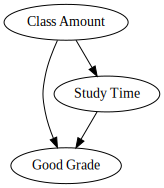

In [27]:
g = gr.Digraph()
g.edge("Class Amount","Good Grade")
g.edge("Study Time","Good Grade")
g.edge("Class Amount","Study Time")

g

In [28]:
def fn_generate_data3(tau,N,p,p0,corr,conf = True):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else: 
        conf_mult=1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    return (Yab,T,C)

In [29]:
tau = 2
corr = 0.5
conf=True
p = 10
p0=0
Nrange = range(10,1000,5) # loop over N values
Y,T,C=fn_generate_data3(tau,N,p,p0,corr,conf)

In [30]:
data = np.concatenate([Y,T,C],axis=1)
data = pd.DataFrame(data)
data.to_csv('Part2.csv')

# When N=100

In [31]:
N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(2.3082462348590584, 0.23478676539344248)

In [32]:
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     96.65
Date:                Fri, 15 Apr 2022   Prob (F-statistic):           2.81e-16
Time:                        01:03:36   Log-Likelihood:                -156.92
No. Observations:                 100   AIC:                             317.8
Df Residuals:                      98   BIC:                             323.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3082      0.235      9.831      0.000       1.842       2.774
const         -0.3503      0.166     -2.110      0.037      -0.680      -0.021
==============================================================================
Omnibus:                        0.158   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.924   Jarque-Bera (JB):                0.112
Skew:                          -0.078   Prob(JB):                        0.946
Kurtosis:                       2.950   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# When N=1000

In [33]:
N = 1000
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = True)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]
tauhat,se_tauhat

(2.1030109583937664, 0.06545280382710945)

In [34]:
const = np.ones([N,1])
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                     1032.
Date:                Fri, 15 Apr 2022   Prob (F-statistic):          4.34e-156
Time:                        01:03:36   Log-Likelihood:                -1452.2
No. Observations:                1000   AIC:                             2908.
Df Residuals:                     998   BIC:                             2918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1030      0.065     32.130      0.000       1.975       2.231
const         -0.0365      0.046     -0.790      0.430      -0.127       0.054
==============================================================================
Omnibus:                        0.368   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.832   Jarque-Bera (JB):                0.453
Skew:                          -0.027   Prob(JB):                        0.797
Kurtosis:                       2.911   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Run a Monte Carlo experiment, and calculate the bias, RMSE and size for N=100 and N=1000

In [35]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data3(tau,N,10,0,corr,conf=True)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:12<00:00, 161.17it/s]


In [36]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=0.0070224888824297034, RMSE=0.16590449885781594, size=0.064
N=1000: bias=0.0008851637151934284, RMSE=0.051784513849357124, size=0.0525


# 2b Experiments have control for confounder  in the DGP

# Run a Monte Carlo experiment, and calculate the bias, RMSE and size for N=100 and N=1000

In [37]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data3(tau,N,p,30,corr,conf=True)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:12<00:00, 165.01it/s]


In [38]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.08093251593354253, RMSE=4.485453808051431, size=0.065
N=1000: bias=0.009609427008887032, RMSE=1.3836842440877082, size=0.053


# 3a Do not control

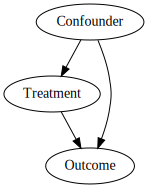

In [39]:
g = gr.Digraph()
g.edge("Confounder","Treatment")
g.edge("Confounder","Outcome")
g.edge("Treatment","Outcome")

g

In [40]:
def fn_generate_data4(tau,N,p,corr):

    nvar = p+1 
    corr = 0.6 
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 2*T+0.6*Y+U

    return (Y,T,S)

In [41]:
tau = 2
corr = 0.6
p = 2
N = 1000
Y,T,S = fn_generate_data4(tau,N,p,corr)

In [42]:
data = np.concatenate([Y,T,S],axis = 1)
data = pd.DataFrame(data)
data.to_csv('dataselectionbias.csv')

In [43]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data4(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:09<00:00, 211.90it/s]


In [44]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.005371551344162723, RMSE=0.20137743983885265, size=0.055
N=1000: bias=0.001986601607253292, RMSE=0.06244782103554409, size=0.04


# 3b Have control for selection bias

In [45]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data4(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 186.59it/s]


In [46]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-1.4086110609715208, RMSE=1.4327532130406704, size=0.999
N=1000: bias=-1.4100147062334325, RMSE=1.4126633811516796, size=1.0
